In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA

In [6]:
df = pd.read_csv('UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
df.rename(columns = {'default.payment.next.month' : 'DEFAULT' }, inplace= True )
df.drop(columns ={'ID'}, inplace = True)
df.head()

In [24]:
df.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64

In [37]:
df.dtypes

LIMIT_BAL    float64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
DEFAULT        int64
dtype: object

SVM dosent support missing values

In [32]:
df['SEX'].unique()

array([2, 1], dtype=int64)

In [34]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

In [38]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0], dtype=int64)

In [41]:
len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)])

68

In [43]:
len(df)

30000

In [44]:
df_no_missing = df.loc[(df['EDUCATION'] !=0 )  &  (df['MARRIAGE'] !=0)]
len(df_no_missing)

29932

In [46]:
df_no_missing['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6], dtype=int64)

# Downsample the dataset
SVM are great with small dataset but not tht good with large ones, this dataset though not huge may take too much time to optimize with cross-validation. So we'll downsample the dataset. Downsampling the customers who defaulted and who did not down to 1000 each.

In [47]:
df_default = df_no_missing[df_no_missing['DEFAULT'] == 1]
df_no_default = df_no_missing[df_no_missing['DEFAULT'] == 0]

In [48]:
df_default_downsample = resample(df_default, replace = False , n_samples=1000, random_state = 42)
len(df_default_downsample)

1000

In [53]:
df_no_default_downsample = resample(df_no_default, n_samples = 1000, random_state = 42, replace = False)
len(df_no_default_downsample)

1000

In [57]:
df_downsample = pd.concat([df_no_default_downsample, df_default_downsample])
len(df_downsample)

2000

# Splitting the data

In [74]:
X = df_downsample.drop('DEFAULT', axis =1).copy()
X.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000.0,2,3,1,28,0,0,0,0,-2,...,50000.0,0.0,0.0,0.0,2500.0,1000.0,0.0,0.0,0.0,0.0
4678,170000.0,1,3,1,29,0,0,0,0,0,...,172307.0,35234.0,32869.0,33862.0,7200.0,7500.0,1200.0,1200.0,1500.0,1300.0
16004,180000.0,2,2,1,29,0,0,0,0,0,...,26310.0,26662.0,26166.0,26176.0,1800.0,1800.0,1500.0,1056.0,950.0,1000.0
22974,210000.0,2,2,2,32,-2,-2,-2,-2,-2,...,410.0,0.0,0.0,0.0,979.0,412.0,0.0,0.0,0.0,0.0
17535,190000.0,2,3,1,45,0,0,0,0,0,...,80548.0,81778.0,83082.0,84811.0,3300.0,3331.0,3359.0,2663.0,2751.0,3000.0


In [62]:
y = df_downsample['DEFAULT'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

# ONE HOT ENCODING

In [65]:
X_encoded = pd.get_dummies(X, columns = ['SEX', 'MARRIAGE', 'EDUCATION', 'PAY_0','PAY_2','PAY_3', 'PAY_4', 'PAY_5','PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000.0,28,100143.0,50456.0,50000.0,0.0,0.0,0.0,2500.0,1000.0,...,0,1,0,0,0,0,0,0,0,0
4678,170000.0,29,165027.0,168990.0,172307.0,35234.0,32869.0,33862.0,7200.0,7500.0,...,0,0,0,1,0,0,0,0,0,0
16004,180000.0,29,25781.0,26000.0,26310.0,26662.0,26166.0,26176.0,1800.0,1800.0,...,0,0,0,1,0,0,0,0,0,0
22974,210000.0,32,355.0,975.0,410.0,0.0,0.0,0.0,979.0,412.0,...,0,1,0,0,0,0,0,0,0,0
17535,190000.0,45,76433.0,78472.0,80548.0,81778.0,83082.0,84811.0,3300.0,3331.0,...,0,0,0,1,0,0,0,0,0,0


# Centring And Scaling
The Radial Basis Function used here assumes that the data is scaled and centered.

In [68]:
X_train,X_test,y_train,y_test = train_test_split(X_encoded, y, random_state = 42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Buiding SVM

In [71]:
cls_svm = SVC(random_state = 42)
cls_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

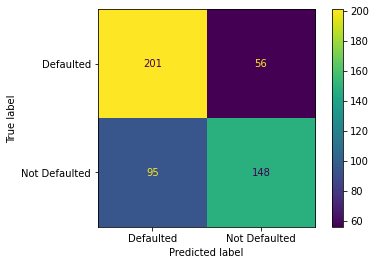

In [75]:
plot_confusion_matrix(cls_svm, X_test_scaled,y_test, display_labels = ['Defaulted' , 'Not Defaulted'])

# Optimizing parameters
Since the model did not perform really well we will optimize the parameters.

In [77]:
param_grid = [{'C' : [0.5,1,10,100],
               'gamma' : ['scale', 1,0.1, 0.01, 0.001, 0.0001], 
              'kernel' : ['rbf']}]
optimal_params = GridSearchCV(SVC(), param_grid , cv = 5, scoring = 'accuracy', verbose = 0)
optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


This is the main reason for downsclaing because cross-validation for huge datset takes too much time.

# FINAL SVM

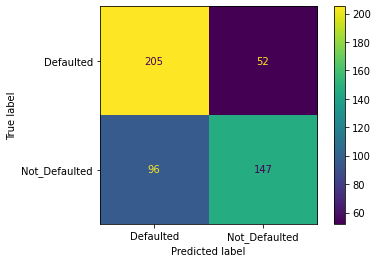

In [80]:
cls_svm = SVC(random_state = 42, C =100, gamma = 0.001)
cls_svm.fit(X_train_scaled, y_train)
plot_confusion_matrix(cls_svm, X_test_scaled, y_test, display_labels = ['Defaulted', 'Not_Defaulted'])

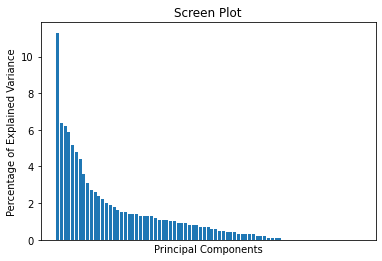

In [86]:
pca= PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
per_var = np.round(pca.explained_variance_ratio_ *100, decimals=1)
labels = [str(x) for x in range (1, len(per_var) +1)]

plt.bar(x= range(1,len(per_var)+1), height = per_var)
plt.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Screen Plot')
plt.show()

In [90]:
train_pc1_coords = X_train_pca[: , 0]
train_pc2_coords = X_train_pca[: , 1]
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

param_grid = [{'C':[1,10,100,1000], 'gamma' : ['scale', 1,0.1,0.001, 0.0001], 'kernel':['rbf']}]
optimal_params = GridSearchCV(SVC(), param_grid, cv= 5, scoring = 'accuracy', verbose=0)
optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


ValueError: 'c' argument has 1500 elements, which is inconsistent with 'x' and 'y' with size 500.

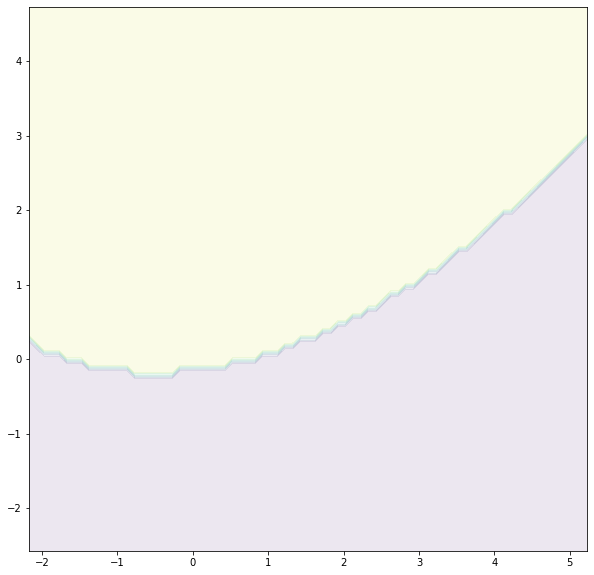

In [95]:
cls_svm = SVC(random_state = 42, C=1000, gamma = 0.001)
cls_svm.fit(pca_train_scaled, y_train)

X_test_pca = pca.transform(X_test_scaled)
test_pc1_coords = X_test_pca[: , 0]
test_pc2_coords = X_test_pca[: , 1]

x_min = test_pc1_coords.min()-1
x_max = test_pc1_coords.max()+1

y_min = test_pc2_coords.min()-1
y_max = test_pc2_coords.max()+1

xx,yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                   np.arange(start = y_min, stop = y_max, step=0.1))

Z = cls_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.contourf(xx,yy,Z,alpha = 0.1)
cmap= colors.ListedColormap(['#e41a1c' , '#4daf4a'])
scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c =y_train, cmap=cmap, s=100, edgecolors = 'k', alpha = 0.7)

legend = ax.legend(scatter.legend_elements()[0],
                  scatter.legend_elements()[1],loc = "upper right")
legend.get_texts()[0].set_text("No Default")
legend.get_texts()[1].set_text("Yes Default")

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision surface using the PCA transformed features')
plt.show()